# Milestone Project 1: Food Vision Project

Objective:
* Beat DeepFood Paper with accuracy of **77.4%**

In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd 

In [2]:
!nvidia-smi -L


GPU 0: NVIDIA GeForce RTX 2060 SUPER (UUID: GPU-75fbeb39-06ef-5e07-53a6-f4208d606d56)


### Mixed Precision Training

Train faster using mixed precision training. However, need access to compute capability of 7.0 or higher

In [3]:
from helper import create_tensorboard_callback, plot_loss_curves, compare_histories

### Using TensorFlow Datasets

TensorFlow provides a list of datasets available to users already in dataset format. This includes Food101.

In [4]:
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders()

In [6]:
# Check if desired dataset is in the list of TFDS datasets
print("food101" in datasets_list)

True


In [7]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned in tuple format (data, label)
                                             with_info=True)

### Exploring the Food101 Dataset

In [8]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [11]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about training sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape},
    Image datatype: {image.dtype},
    Target class from Food101 (tensor form): {label},
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3),
    Image datatype: <dtype: 'uint8'>,
    Target class from Food101 (tensor form): 75,
    Class name (str form): pho
    


In [13]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

In [14]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

(-0.5, 511.5, 511.5, -0.5)

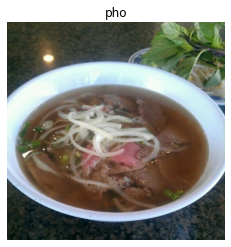

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt 

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

### Create preprocessing functions for data

Neural networks perform best when batched and normalized.

Current data:
* In `uint8` datatype
* Comprised of differently shaped images
* Not normalized (Between 0 & 255)

Note: Since the base model will be EfficientNetBX model it will contain an rescaling layer.

In [16]:
# Make a function for preprocessing images

def preprocess_img(image, label, img_shape=224):
    """
    Convert image datatype from 'uint8 -> 'float32'
    and reshapes image to [img_shape, img_shape, colour_channels]
    """

    img = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(img, tf.float32), label

In [17]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 48  51  30]
  [ 49  52  31]
  [ 50  55  33]
  ...
  [ 93 120  77]
  [ 87 112  70]
  [ 80 105  63]]

 [[ 43  46  25]
  [ 46  49  28]
  [ 49  54  32]
  ...
  [ 95 122  77]
  [ 90 117  72]
  [ 83 110  65]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[ 46.2551    49.2551    28.255102]
  [ 49.954082  54.954082  32.954082]
  [ 42.494896  50.494896  27.494898]
  ...
  [ 97.50995  129.86195   81.4385  ]
  [ 94.02041  122.21427   77.33163 ]
  [ 86.42833  112.71404   68.78547 ]]

 [[ 45.336735  48.336735  27.336735]
  [ 53.714287  58.714287  36.714287]
  [ 40.44388   48.44388   25.443878]
  ...
  [ 92.948906 128.3213    74.52029 ]
  [ 85.48981  117.27552   67.41838 ]
  [ 90.70417  122.48989   72.632744]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


### Batch and Prepare Datasets

In [18]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### What is happening?

1. Mapped the preprocessing function `preprocess_img` to the training and test datasets
2. Shuffle the training dataset
3. Batch the training and test datasets
4. Prefetch loads the next batch while the model is learning the features on the current batch

### Create modelling callbacks

Callbacks to create:
* TensorBoard callback to log training results
* ModelCheckpoint callback to save model's progress after feature extraction

In [21]:
# Create Modelcheckpoint callback
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      verbose=0)

### Setup Mixed Precision Training

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance

In [22]:
# Turn on mixed orecision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
# mixed_precision.set_global_policy("mixed_float32") # To switch back


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060 SUPER, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060 SUPER, compute capability 7.5


In [23]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Build feature extraction model

In [24]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False) # Make sure layers which should be in inference stay that way
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [26]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Above:
* `layer.name`: The readable name of a particular layer
* `layer.trainable`: Is the layer trainable or not? (`False` if the weights are frozen)
* `layer.dtype`: The datatype a layer stores its variables in
* `layer.dtype_policy`: The datatype policy a layer computes on its variables with

In [27]:
# Check the efficientnet layer's policies
for layer in model.layers[1].layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

### Fit the feature extraction model

In [28]:
feature_extraction_history = model.fit(train_data,
                                        epochs=3,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15*len(test_data)),
                                        callbacks=[create_tensorboard_callback(dir_name='training_logs',experiment_name='efficientnetb0_101_classes_all_data_feature_extraction'),
                                                    model_checkpoint])

Saving TensorBoard log files to: training_logs\efficientnetb0_101_classes_all_data_feature_extraction\20220919-183612
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8215 - accuracy: 0.5573INFO:tensorflow:Assets written to: model_checkpoints\cp.ckpt\assets


INFO:tensorflow:Assets written to: model_checkpoints\cp.ckpt\assets


2368/2368 [==============================] - 152s 61ms/step - loss: 1.8215 - accuracy: 0.5573 - val_loss: 1.2236 - val_accuracy: 0.6777
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2934 - accuracy: 0.6668INFO:tensorflow:Assets written to: model_checkpoints\cp.ckpt\assets


INFO:tensorflow:Assets written to: model_checkpoints\cp.ckpt\assets


2368/2368 [==============================] - 144s 61ms/step - loss: 1.2934 - accuracy: 0.6668 - val_loss: 1.1326 - val_accuracy: 0.6962
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1434 - accuracy: 0.7031INFO:tensorflow:Assets written to: model_checkpoints\cp.ckpt\assets


INFO:tensorflow:Assets written to: model_checkpoints\cp.ckpt\assets


2368/2368 [==============================] - 145s 61ms/step - loss: 1.1434 - accuracy: 0.7031 - val_loss: 1.0895 - val_accuracy: 0.7063


In [30]:
# Evaluate the model
feature_extraction_model_results = model.evaluate(test_data)

790/790 [==============================] - 31s 39ms/step - loss: 1.0910 - accuracy: 0.7037


### Saving the model

In [31]:
model.save('project_1_feature_extraction_model')

INFO:tensorflow:Assets written to: project_1_feature_extraction_model\assets


INFO:tensorflow:Assets written to: project_1_feature_extraction_model\assets


In [32]:
loaded_model = tf.keras.models.load_model('project_1_feature_extraction_model')

In [33]:
loaded_feature_extraction_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 33s 40ms/step - loss: 1.0910 - accuracy: 0.7037


In [34]:
np.isclose(np.array(feature_extraction_model_results),np.array(loaded_feature_extraction_model_results))

array([ True,  True])

In [35]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Fine-tuning

Fine-tuning with all layers unfrozen

In [36]:
for layer in loaded_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [37]:
loaded_model.layers[1].trainable = True

In [38]:
for layer in loaded_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [39]:
# Setup EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Create ModelCheckpoint callback
checkpoint_path = 'model_checkpoints/cp_fine_tuning_1.ckpt'
model_checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        monitor='val_loss',
                                                        save_best_only=True,
                                                        verbose=0)

In [40]:
# Create learning rate reduction callback
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            factor=0.2,
                                                            patience=2,
                                                            verbose=1,
                                                            min_lr=1e-7)

In [41]:
loaded_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10x lower than feature extraction learning rate for fine-tuning
                     metrics=['accuracy'])

In [42]:
history_fine_tuning_1 = loaded_model.fit(train_data,
                                         epochs=100,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name='training_logs',experiment_name='efficientnetb0_101_all_classes_fine_tuning_v1'),
                                                    model_checkpoint_2,
                                                    early_stopping,
                                                    reduce_learning_rate])

Saving TensorBoard log files to: training_logs\efficientnetb0_101_all_classes_fine_tuning_v1\20220919-185611
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9194 - accuracy: 0.7535INFO:tensorflow:Assets written to: model_checkpoints\cp_fine_tuning_1.ckpt\assets


INFO:tensorflow:Assets written to: model_checkpoints\cp_fine_tuning_1.ckpt\assets


2368/2368 [==============================] - 408s 167ms/step - loss: 0.9194 - accuracy: 0.7535 - val_loss: 0.8805 - val_accuracy: 0.7556 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.8403INFO:tensorflow:Assets written to: model_checkpoints\cp_fine_tuning_1.ckpt\assets


INFO:tensorflow:Assets written to: model_checkpoints\cp_fine_tuning_1.ckpt\assets


2368/2368 [==============================] - 393s 166ms/step - loss: 0.5795 - accuracy: 0.8403 - val_loss: 0.7762 - val_accuracy: 0.7892 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 353s 149ms/step - loss: 0.3297 - accuracy: 0.9065 - val_loss: 0.8325 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9483
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 353s 149ms/step - loss: 0.1751 - accuracy: 0.9483 - val_loss: 0.9793 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 353s 149ms/step - loss: 0.0359 - accuracy: 0.9920 - val_loss: 1.0334 - val_accuracy: 0.8008 - lr: 2.0000e-05


In [44]:
fine_tuning_results_1 = loaded_model.evaluate(test_data)

790/790 [==============================] - 32s 40ms/step - loss: 1.0560 - accuracy: 0.7979


In [45]:
loaded_model.save('fine_tuning_model_1')

INFO:tensorflow:Assets written to: fine_tuning_model_1\assets


INFO:tensorflow:Assets written to: fine_tuning_model_1\assets


In [46]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.
    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred)
        y_pred: Array of predicted labels (must be same shape as y_true)
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used
        figsize: Size of output figure (default=(10,10))
        text_size: Size of output figure text (default=15)
        norm: normalize values or not (default=False)
        savefig: save confusion matrix to file (default=False)
    
    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred
    """

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    n_classes = cm.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    # colours will represent how 'correct' a class is, darker == better
    cax = ax.matshow(cm, cmap=plt.cm.Blues)

    # Check for list of classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted Label",
           ylabel="True Label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ### Changed: Plot x labels veritcally
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
                     horizontalalignment='center',
                     color='white' if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i,j]}",
                     horizontalalignment='center',
                     color='white' if cm[i, j] > threshold else "black",
                     size=text_size)

    if savefig:
        fig.savefig('confusion_matrix.png')


In [58]:
pred_probs = []
y_labels = []

for images, labels in test_data.unbatch():
    pred_probs.append(loaded_model.predict(tf.expand_dims(images,axis=0)).argmax())
    y_labels.append(labels.numpy())


print(pred_probs[:10])
print(y_labels[:10])


[100, 57, 46, 16, 73, 1, 45, 34, 23, 30]
[42, 57, 46, 83, 15, 80, 45, 28, 23, 30]


In [59]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [60]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_probs)
sklearn_accuracy


0.797940594059406

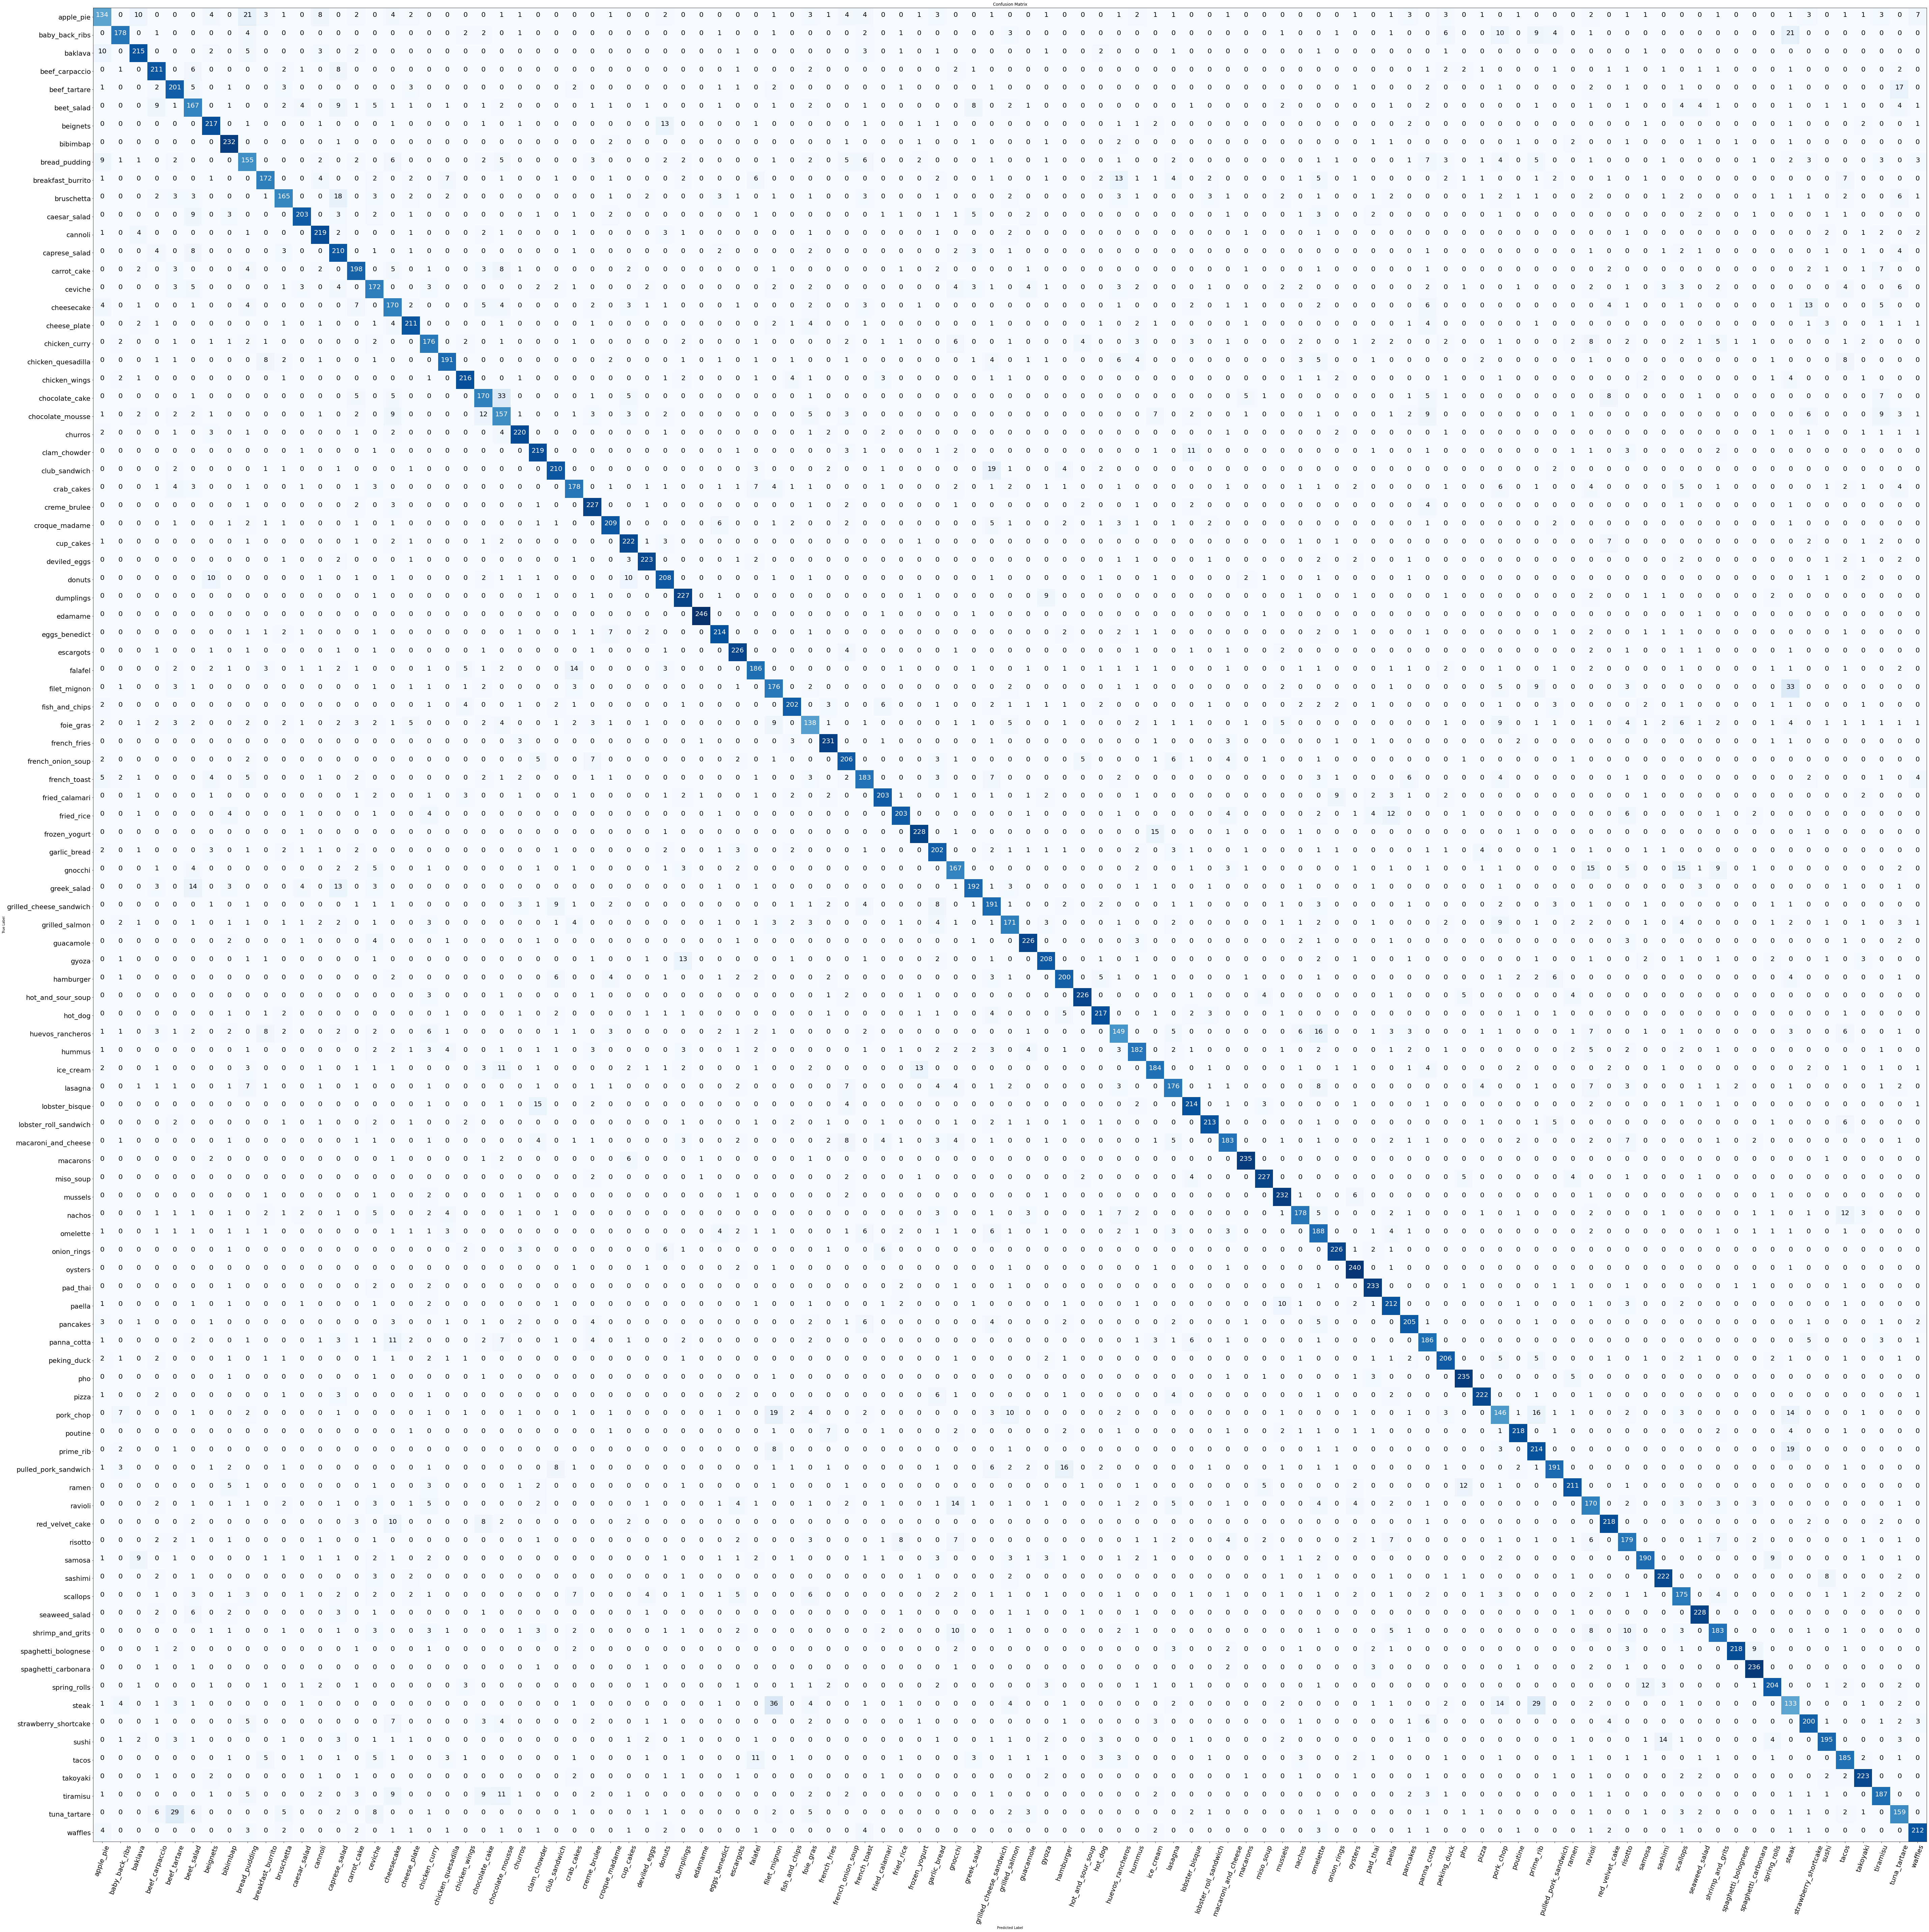

In [61]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_probs,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

### Model Performance

Overall our model achieved an accuracy of **79.8%** over less than 10 epochs. This model slightly outperforms DeepFood's paper highest achieved accuracy of 77.4%. With some additional fine-tuning this model can probably pass an accuracy of 80%.